# Sentimental analysis on Twitter about the sanctions of the United States on Iran

# I) Importing libraries and extracting data using Tweepy :

In [1]:
import tweepy 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import community
from textblob import TextBlob
from plotly.graph_objs import *
import networkx as nx
from datetime import datetime
import re
import seaborn as sns
import iso8601

## Extracting Data with Twitter API (Tweepy)

In [2]:
consumer_key = "fmvmtpE1lBi1RITgpavC30kp9"
consumer_secret = "CZO53RRpSPyojc7vDHmX47PCEltBwQMMJ4dQFon7xhgplFQwOY"
access_key = "1059027920369389568-DaLYe2ehXXGDbPBH0z64HBcjetSlSV"
access_secret = "NlocC55FlEbj3wh6dtwS0EZbvVydAEirm7iiTAP6YpA64"

OAUTH_KEYS = {'consumer_key':consumer_key, 'consumer_secret':consumer_secret,
 'access_token_key':access_key, 'access_token_secret':access_secret}
auth = tweepy.OAuthHandler(OAUTH_KEYS['consumer_key'], OAUTH_KEYS['consumer_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
search="iran sanctions OR #iransanctions"
search = tweepy.Cursor(api.search, q=search,since= "2018-11-03",tweet_mode='extended').items() 

In [ ]:
tweetTxt = []
username = []
nbrRetweet = []
tweetId=[]
retweetedId=[]
creationDate=[]

for tweet in search:
    creationDate.append(tweet.created_at)
    tweetTxt.append(tweet.full_text)
    username.append(tweet.user._json["name"])
    nbrRetweet.append(tweet.retweet_count)
    tweetId.append(tweet.id_str)
    if hasattr(tweet, 'retweeted_status'):
        retweetedId.append(tweet.retweeted_status.id_str)
    else:
        retweetedId.append("0")

In [ ]:
# converting data to Pandas Objects
usaSanctionsTweets = pd.DataFrame()
usaSanctionsTweets['tweetId'] = tweetId
usaSanctionsTweets['creationDate'] = creationDate
usaSanctionsTweets['username'] = username
usaSanctionsTweets['tweetTxt'] =tweetTxt
usaSanctionsTweets['retweetedId'] = retweetedId
usaSanctionsTweets['nbrRetweet'] = nbrRetweet
usaSanctionsTweets['creationDate'] = pd.to_datetime(usaSanctionsTweets['creationDate'])
usaSanctionsTweets['usa-creationDate'] = usaSanctionsTweets['creationDate'] - pd.Timedelta(hours=5)

In [ ]:
AfterSanctionsTweet=usaSanctionsTweets[usaSanctionsTweets['usa-creationDate'] > pd.to_datetime('2018-11-05 06:00:00')]
BeforeSanctionsTweet=usaSanctionsTweets[usaSanctionsTweets['usa-creationDate'] < pd.to_datetime('2018-11-05 00:00:00')]
usaSanctionsTweets.to_csv('usaSanctionsTweets.csv')
AfterSanctionsTweet.to_csv('AfterSanctionsTweet.csv')
BeforeSanctionsTweet.to_csv('BeforeSanctionsTweet.csv')

In [477]:
consumer_key = "fmvmtpE1lBi1RITgpavC30kp9"
consumer_secret = "CZO53RRpSPyojc7vDHmX47PCEltBwQMMJ4dQFon7xhgplFQwOY"
access_key = "1059027920369389568-DaLYe2ehXXGDbPBH0z64HBcjetSlSV"
access_secret = "NlocC55FlEbj3wh6dtwS0EZbvVydAEirm7iiTAP6YpA64"

OAUTH_KEYS = {'consumer_key':consumer_key, 'consumer_secret':consumer_secret,
 'access_token_key':access_key, 'access_token_secret':access_secret}
auth = tweepy.OAuthHandler(OAUTH_KEYS['consumer_key'], OAUTH_KEYS['consumer_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
search="iran sanctions OR #iransanctions OR usa iran sanctions OR #usairansanctions"
search = tweepy.Cursor(api.search, q=search,since= "2018-11-05",until="2018-11-06",tweet_mode='extended').items() # ici on spécifie le mot clé

# II) DATA ANALYSIS :

# Tweets and retweets before Iran sanctions

In [2]:
BeforeSanctionsTweet = pd.read_csv('BeforeSanctionsTweet.csv')
BeforeSanctionsTweet=BeforeSanctionsTweet[BeforeSanctionsTweet['usa-creationDate'] > '2018-11-04 06:00:00']
BeforeSanctionsTweet.shape

(25132, 8)

## Tweets between 7h et 9h 4 Nov

In [3]:
graphBeforeSanctions=BeforeSanctionsTweet[BeforeSanctionsTweet['usa-creationDate'] < '2018-11-04 09:00:00']
graphBeforeSanctions=graphBeforeSanctions[graphBeforeSanctions['usa-creationDate'] > '2018-11-04 07:00:00']
graphBeforeSanctions.shape

(2373, 8)

## Graph of tweets and retweets

In [4]:
graph = nx.DiGraph()
links = []
color_map = []
# selecting only tweets with retweets
graphBeforeSanctions=graphBeforeSanctions[graphBeforeSanctions['retweetedId']!=0]

for sanctions in graphBeforeSanctions.values:
    links.append((sanctions[5],sanctions[1]))
    
edges = len(links)
edges

1891

In [5]:
retweetBSgraph=graphBeforeSanctions
retweetBSNames = []
p = re.compile(r'\bRT @+[\w]+:*\b')
retweetBSgraph['retweetNames']=[p.findall(t)[0] for t in retweetBSgraph['tweetTxt'].values ]

TOP8= retweetBSgraph.groupby(by = 'retweetNames').count().sort_values('nbrRetweet' , ascending=False)['nbrRetweet'].index[:8]
list(TOP8)

['RT @SecPompeo',
 'RT @StateDept',
 'RT @erinmcunningham',
 'RT @girirajsinghbjp',
 'RT @BenjaminNorton',
 'RT @USAdarFarsi',
 'RT @America_1st_NOW',
 'RT @WSJ']

In [6]:
mostRetweeted={}

for t in retweetBSgraph.values:
    if t[8] in TOP8 and t[8] in mostRetweeted :
        if t[5] not in mostRetweeted[t[8]] :
            mostRetweeted[t[8]].append(t[5])
    elif t[8] in TOP8 :
            mostRetweeted[t[8]]=[t[5]]

In [7]:
for m in mostRetweeted :
    print(m,'len : ' ,len(mostRetweeted[m]))

RT @SecPompeo len :  1
RT @StateDept len :  14
RT @erinmcunningham len :  1
RT @USAdarFarsi len :  1
RT @girirajsinghbjp len :  1
RT @BenjaminNorton len :  2
RT @WSJ len :  2
RT @America_1st_NOW len :  1


In [8]:
graph.add_edges_from(links)
options = {
    'line_color': '#A4A4A4',
    'linewidths': 0,
    'width': 0.1,
} 

In [9]:
## coloring nodes
sizeNode=[]
color_map=[]
loc=0
for nd in nx.degree(graph):
    found=False
    loc=0
    for m in mostRetweeted:
        if(found):
            break
        if nd[0] in mostRetweeted[m]:
            found = True
        loc = loc+1
        if(found == True):
            sizeNode.append(50)
            # SecPompeo : 1st
            if loc == 1:
                color_map.append('#ADFF00')
            # StateDept : 2nd
            elif loc == 2:
                color_map.append('#FF0000')                
            # erinmcunningham : 3rd
            elif loc == 3:
                color_map.append('#FFD900')
             # USAdarFarsi : 6th
            elif loc == 4:
                color_map.append('#03FF00')
              # girirajsinghbjp : 4th 
            elif loc == 5:
                color_map.append('#00FFDE')
              # BenjaminNorton : 5th
            elif loc == 6:
                color_map.append('#1200FF')
              # WSJ : 8 th
            elif loc == 7:
                color_map.append('#B34DFF')
              # America_1st_NOW : 7 th
            elif loc == 8:
                color_map.append('#000000')
    if(found == False ) :
        color_map.append('#138DFD')
        sizeNode.append(20)

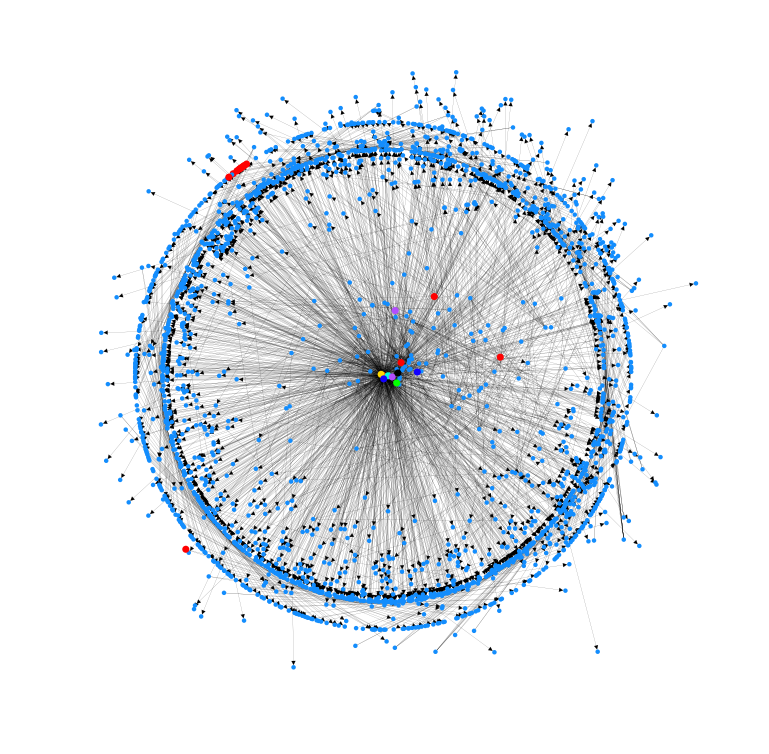

In [10]:
plt.figure(figsize=(10,10)) 
nx.draw_kamada_kawai(graph,**options,node_size=sizeNode , node_color=color_map )
plt.savefig("graphBS.png")

### graph analysis

In [11]:
print(nx.info(graph))

Name: 
Type: DiGraph
Number of nodes: 2276
Number of edges: 1891
Average in degree:   0.8308
Average out degree:   0.8308


In [12]:
nx.density(graph)

0.0003652059715328608

In [13]:
comunities = next(community.girvan_newman(graph))
len(comunities)

386

### First eight retweets

In [14]:
BeforeSanctionsTweet=BeforeSanctionsTweet[BeforeSanctionsTweet['retweetedId']!=0]
AllretweetBSNames = []
p = re.compile(r'\bRT @+[\w]+:*\b')
BeforeSanctionsTweet['retweetNames']=[p.findall(t)[0] for t in BeforeSanctionsTweet['tweetTxt'].values ]

In [15]:
TOP8= BeforeSanctionsTweet.groupby(by = 'retweetNames').count().sort_values('nbrRetweet' , ascending=False)['nbrRetweet'].index[:8]
list(TOP8)

['RT @wikileaks',
 'RT @SecPompeo',
 'RT @FoxNews',
 'RT @StateDept',
 'RT @BenjaminNorton',
 'RT @erinmcunningham',
 'RT @FoxNewsSunday',
 'RT @RealSaavedra']

In [16]:
numberOfRetweetBS=[]
for name in TOP8 :
    numberOfRetweetBS.append(BeforeSanctionsTweet[BeforeSanctionsTweet['retweetNames']==name].count()[0])
numberOfRetweetBS

[3456, 2416, 996, 771, 544, 488, 415, 374]

In [17]:
dataRetweetsBS = {}
i=0
for name in TOP8 :
    dataRetweetsBS[name]=numberOfRetweetBS[i]
    i=i+1 
dataRetweetsBS

{'RT @wikileaks': 3456,
 'RT @SecPompeo': 2416,
 'RT @FoxNews': 996,
 'RT @StateDept': 771,
 'RT @BenjaminNorton': 544,
 'RT @erinmcunningham': 488,
 'RT @FoxNewsSunday': 415,
 'RT @RealSaavedra': 374}

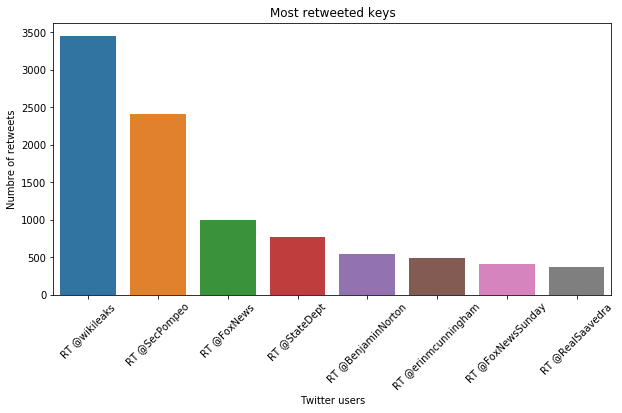

In [18]:
d = pd.DataFrame({'Twitter users': list(dataRetweetsBS.keys()),
                  'Numbre of retweets': list(dataRetweetsBS.values())})

plt.figure(figsize=(10,5))
sns.barplot(data=d, x= "Twitter users", y = "Numbre of retweets")
plt.xticks(rotation=45)
plt.title("Most retweeted keys")
plt.show()
#plt.savefig("mostRetweetedBS.png")

## Tweets Analysis

In [19]:
BeforeSanctionsTweet["polarity"] = [TextBlob(txt).sentiment.polarity for txt in BeforeSanctionsTweet["tweetTxt"]]
BeforeSanctionsTweet["subjectivity"] = [TextBlob(txt).sentiment.subjectivity for txt in BeforeSanctionsTweet["tweetTxt"]]

In [20]:
negative=0
positive=0
Neutre=0
opinionList=[]

for pol in BeforeSanctionsTweet["polarity"]:
    if pol>0.05 : 
        opinionList.append("positive")
        positive=positive+1
    elif pol < -0.05:
        opinionList.append("negative")
        negative=negative+1
    else : 
        opinionList.append("Neutre")
        Neutre=Neutre+1
        
BeforeSanctionsTweet["opinion"]=opinionList

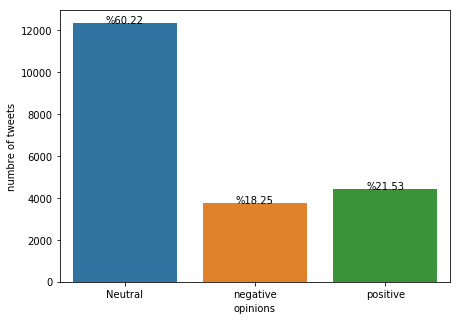

In [21]:
d = pd.DataFrame({'opinions': ['Neutral','negative','positive'],
                  'Numbre of tweets': [Neutre,negative,positive]})

plt.figure(figsize=(7,5))

ax = sns.barplot(data=d, x= "opinions", y = "Numbre of tweets" )
ax.set(ylabel = 'numbre of tweets')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '%{:1.2f}'.format(height/(Neutre+negative+positive)*100),
            ha="center" ) 
plt.show()
#plt.savefig("barSentimentsBS.png")

### Tweets and retweets frequency one day before the sanctions 

In [22]:
convertedDate=[]

for t in BeforeSanctionsTweet['usa-creationDate'].values : 
    convertedDate.append(datetime.strptime(t,'%Y-%m-%d %H:%M:%S'))

BeforeSanctionsTweet["convertedDate"]=convertedDate

In [23]:
time = pd.date_range(start=BeforeSanctionsTweet["convertedDate"][25126],end=BeforeSanctionsTweet["convertedDate"][1], freq='30min')
time_n=len(time)

rangeDate = []
i=1
for date in BeforeSanctionsTweet["convertedDate"]:
    if date >= time[-i]:
        rangeDate.append(time[-i])
    else:
        i+=1
        rangeDate.append(time[-i])
BeforeSanctionsTweet['dateRange'] = rangeDate

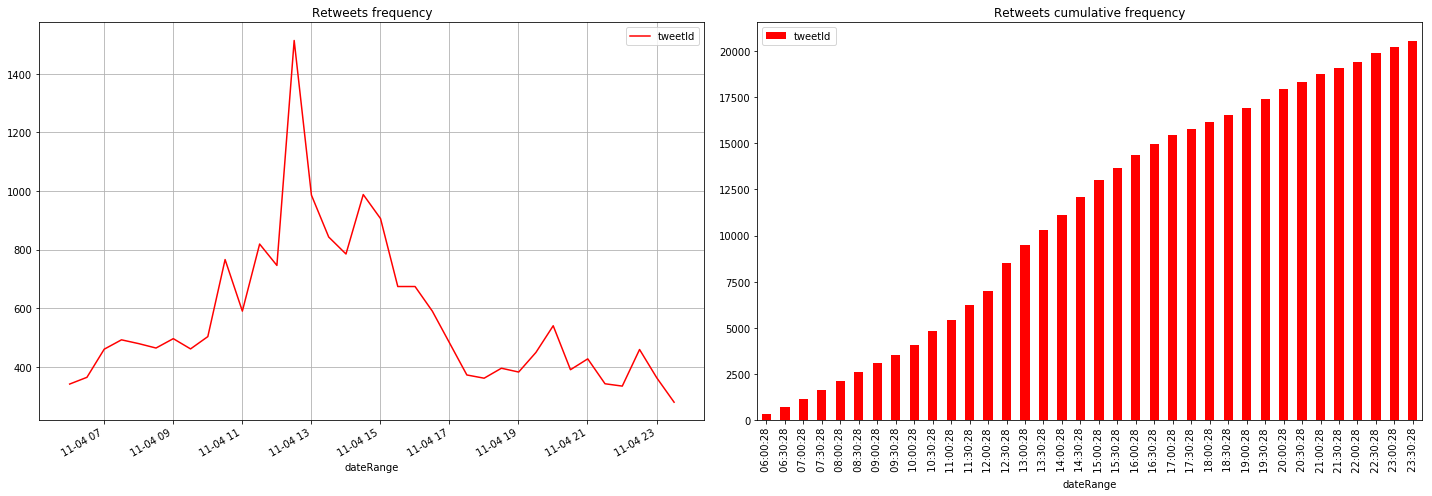

In [24]:
fig,ax = plt.subplots(1,2,figsize=(20,7))
BeforeSanctionsTweet[["dateRange","tweetId"]].groupby('dateRange').count().plot(title="Retweets frequency" , color='r' ,kind='line',grid=True,ax=ax[0])
BeforeSanctionsTweet[["dateRange","tweetId"]].groupby('dateRange').count().cumsum().plot(title="Retweets cumulative frequency" , color='red',kind='bar',ax=ax[1])
ax[1].set_xticklabels([tick.get_text()[10:] for tick in ax[1].get_xticklabels()])

plt.tight_layout()
#plt.savefig("frequenceTweetsBS.png")

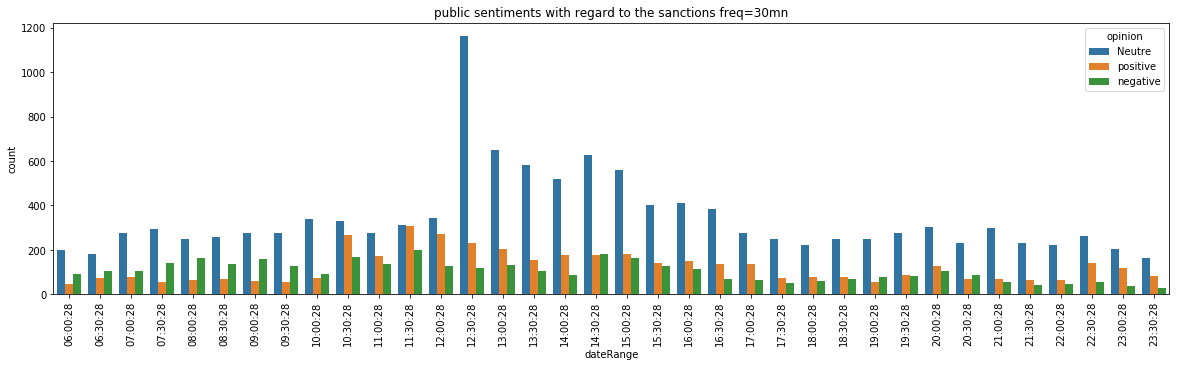

In [25]:
plt.figure(figsize=(20,5))
ax =sns.countplot(data = BeforeSanctionsTweet,x = 'dateRange',hue='opinion')
ax.set_xticklabels([tick.get_text()[11:-10] for tick in ax.get_xticklabels()])
plt.xticks(rotation=90)
plt.title('public sentiments with regard to the sanctions freq=30mn')
plt.show()

# After Sanctions tweets :

In [26]:
AfterSanctionsTweet = pd.read_csv('AfterSanctionsTweet.csv')
AfterSanctionsTweet=AfterSanctionsTweet[AfterSanctionsTweet['usa-creationDate'] < '2018-11-06 00:00:00']
AfterSanctionsTweet.shape

(57211, 8)

### Tweets between 7h and 9h 5 Nov

In [27]:
graphAfterSanctions=AfterSanctionsTweet[AfterSanctionsTweet['usa-creationDate'] < '2018-11-05 09:00:00']
graphAfterSanctions=graphAfterSanctions[graphAfterSanctions['usa-creationDate'] > '2018-11-05 07:00:00']
graphAfterSanctions=graphAfterSanctions[graphAfterSanctions['retweetedId']!=0]
graphAfterSanctions.shape

(5736, 8)

## Graph of tweets and retweets

In [28]:
graphAS = nx.DiGraph()
links = []
color_map = []
stop=1
# selecting only tweets with retweets
for sanctions in graphAfterSanctions.values:
    links.append((sanctions[5],sanctions[1]))
    if(stop == 5500):
        break
    stop=stop+1
        
edges = len(links)
edges

5500

In [29]:
retweetASgraph=graphAfterSanctions
retweetASNames = []
p = re.compile(r'\bRT @+[\w]+:*\b')
retweetASgraph['retweetNames']=[p.findall(t)[0] for t in retweetASgraph['tweetTxt'].values ]

TOP8= retweetASgraph.groupby(by = 'retweetNames').count().sort_values('nbrRetweet' , ascending=False)['nbrRetweet'].index[:8]
list(TOP8)

['RT @FoxNews',
 'RT @foxandfriends',
 'RT @Rise_Soar_BFree',
 'RT @spectatorindex',
 'RT @StateDept',
 'RT @Reuters',
 'RT @wikileaks',
 'RT @NevadaJack2']

In [30]:
mostRetweeted={}
for t in retweetASgraph.values:
    if t[8] in TOP8 and t[8] in mostRetweeted :
        if t[5] not in mostRetweeted[t[8]] :
            mostRetweeted[t[8]].append(t[5])
    elif t[8] in TOP8 :
            mostRetweeted[t[8]]=[t[5]]

In [31]:
for m in mostRetweeted :
    print(m,'len : ' ,len(mostRetweeted[m]))

RT @StateDept len :  8
RT @spectatorindex len :  3
RT @NevadaJack2 len :  1
RT @wikileaks len :  2
RT @FoxNews len :  13
RT @Reuters len :  16
RT @Rise_Soar_BFree len :  1
RT @foxandfriends len :  2


In [32]:
graphAS.add_edges_from(links)
options = {
    'line_color': '#A4A4A4',
    'linewidths': 0,
    'width': 0.1,
} 

In [33]:
## coloring nodes
sizeNode=[]
color_map=[]
loc=0
for nd in nx.degree(graphAS):
    found=False
    loc=0
    for m in mostRetweeted:
        if(found):
            break
        if nd[0] in mostRetweeted[m]:
            found = True
        loc = loc+1
        if(found == True):
            sizeNode.append(50)
            # SecPompeo : 1st
            if loc == 1:
                color_map.append('#ADFF00')
            # StateDept : 2nd
            elif loc == 2:
                color_map.append('#FF0000')                
            # erinmcunningham : 3rd
            elif loc == 3:
                color_map.append('#FFD900')
             # USAdarFarsi : 6th
            elif loc == 4:
                color_map.append('#03FF00')
              # girirajsinghbjp : 4th 
            elif loc == 5:
                color_map.append('#00FFDE')
              # BenjaminNorton : 5th
            elif loc == 6:
                color_map.append('#1200FF')
              # WSJ : 8 th
            elif loc == 7:
                color_map.append('#B34DFF')
              # America_1st_NOW : 7 th
            elif loc == 8:
                color_map.append('#000000')
    if(found == False ) :
        color_map.append('#138DFD')
        sizeNode.append(20)

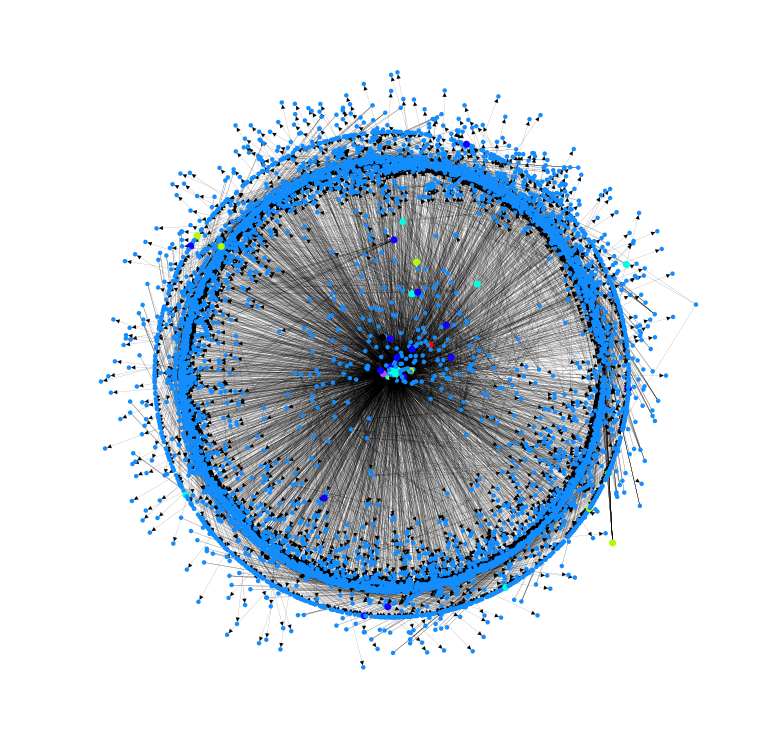

In [34]:
plt.figure(figsize=(10,10))
nx.draw_kamada_kawai(graphAS,**options,node_size=sizeNode , node_color=color_map)
plt.savefig("graphAS.png")

### graph analysis

In [35]:
print(nx.info(graphAS))

Name: 
Type: DiGraph
Number of nodes: 6371
Number of edges: 5500
Average in degree:   0.8633
Average out degree:   0.8633


In [36]:
nx.density(graphAS)

0.00013552382545812598

In [37]:
comunities = next(community.girvan_newman(graphAS))
len(comunities)

872

### First eight retweets

In [38]:
AfterSanctionsTweet=AfterSanctionsTweet[AfterSanctionsTweet['retweetedId']!=0]
AllretweetASNames = []
p = re.compile(r'\bRT @+[\w]+:*\b')
AfterSanctionsTweet['retweetNames']=[p.findall(t)[0] for t in AfterSanctionsTweet['tweetTxt'].values ]

In [39]:
TOP8= AfterSanctionsTweet.groupby(by = 'retweetNames').count().sort_values('nbrRetweet' , ascending=False)['nbrRetweet'].index[:8]
list(TOP8)

['RT @StateDept',
 'RT @realTylerZed',
 'RT @SecPompeo',
 'RT @WhiteHouse',
 'RT @Rise_Soar_BFree',
 'RT @wikileaks',
 'RT @FoxNews',
 'RT @spectatorindex']

In [40]:
numberOfRetweetAS=[]
for name in TOP8 :
    numberOfRetweetAS.append(AfterSanctionsTweet[AfterSanctionsTweet['retweetNames']==name].count()[0])
numberOfRetweetAS

[2996, 2466, 1900, 1710, 1312, 1248, 1148, 1108]

In [41]:
dataRetweetsAS = {}
i=0
for name in TOP8 :
    dataRetweetsAS[name]=numberOfRetweetAS[i]
    i=i+1 
dataRetweetsAS

{'RT @StateDept': 2996,
 'RT @realTylerZed': 2466,
 'RT @SecPompeo': 1900,
 'RT @WhiteHouse': 1710,
 'RT @Rise_Soar_BFree': 1312,
 'RT @wikileaks': 1248,
 'RT @FoxNews': 1148,
 'RT @spectatorindex': 1108}

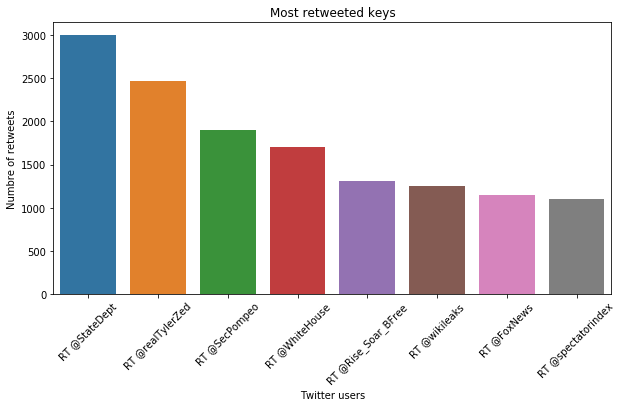

In [42]:
d = pd.DataFrame({'Twitter users': list(dataRetweetsAS.keys()),
                  'Numbre of retweets': list(dataRetweetsAS.values())})

plt.figure(figsize=(10,5))
ax = sns.barplot(data=d, x= "Twitter users", y = "Numbre of retweets")
ax.set(ylabel = 'Numbre of retweets')
plt.xticks(rotation=45)
plt.title("Most retweeted keys")
plt.show()
#plt.savefig("mostRetweetedBS.png")

## Sentimental Analysis

In [43]:
AfterSanctionsTweet["polarity"] = [TextBlob(txt).sentiment.polarity for txt in AfterSanctionsTweet["tweetTxt"]]
AfterSanctionsTweet["subjectivity"] = [TextBlob(txt).sentiment.subjectivity for txt in AfterSanctionsTweet["tweetTxt"]]

In [44]:
negative=0
positive=0
Neutre=0
opinionList=[]

for sub in AfterSanctionsTweet["polarity"]:
    if sub>0.05 : 
        opinionList.append("positive")
        positive=positive+1
    elif sub < -0.05:
        opinionList.append("negative")
        negative=negative+1
    else : 
        opinionList.append("Neutral")
        Neutre=Neutre+1
        
AfterSanctionsTweet["opinion"]=opinionList

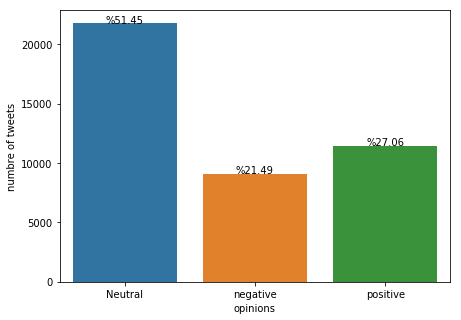

In [45]:
d = pd.DataFrame({'opinions': ['Neutral','negative','positive'],
                  'numbre of tweets': [Neutre,negative,positive]})

plt.figure(figsize=(7,5))

ax = sns.barplot(data=d, x= "opinions", y = "numbre of tweets" )
ax.set(ylabel = 'numbre of tweets')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '%{:1.2f}'.format(height/(Neutre+negative+positive)*100),
            ha="center") 
plt.show()

### Tweets and retweets frequency one day before the sanctions 

In [46]:
convertedDate=[]

for t in AfterSanctionsTweet['usa-creationDate'].values : 
    convertedDate.append(datetime.strptime(t,'%Y-%m-%d %H:%M:%S'))

AfterSanctionsTweet["convertedDate"]=convertedDate

In [47]:
time = pd.date_range(start=AfterSanctionsTweet["convertedDate"][70197],end=AfterSanctionsTweet["convertedDate"][12991], freq='30min')
time_n=len(time)

rangeDate = []
i=1
for date in AfterSanctionsTweet["convertedDate"]:
    if date >= time[-i]:
        rangeDate.append(time[-i])
    else:
        i+=1
        rangeDate.append(time[-i])
AfterSanctionsTweet['dateRange'] = rangeDate

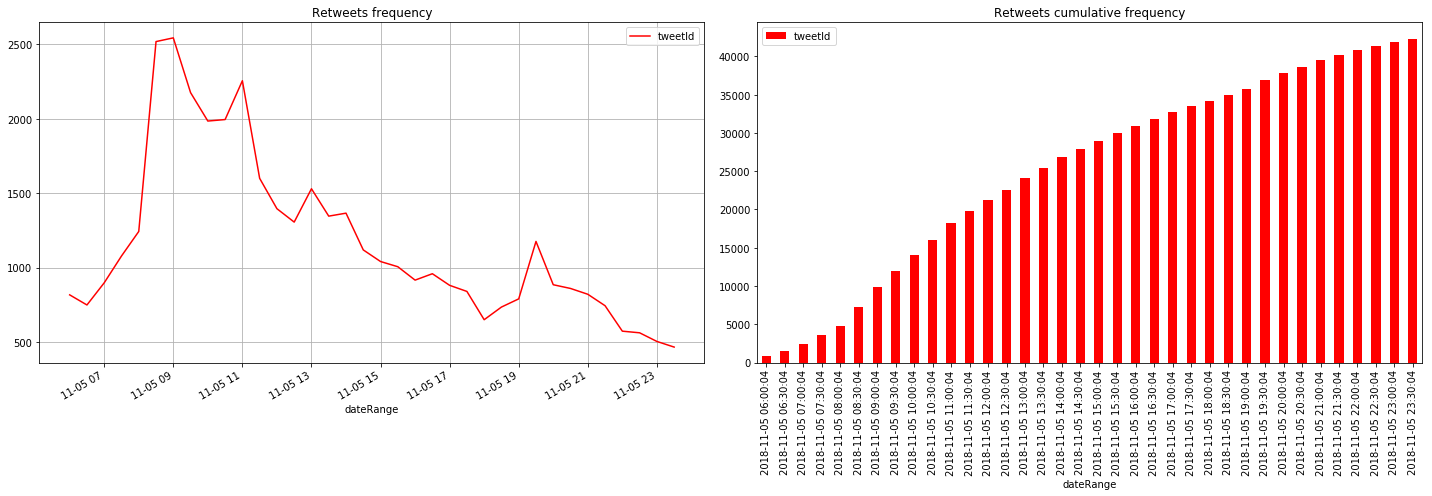

In [48]:
fig,ax = plt.subplots(1,2,figsize=(20,7))
AfterSanctionsTweet[["dateRange","tweetId"]].groupby('dateRange').count().plot(title="Retweets frequency" , color='r' ,kind='line',grid=True,ax=ax[0])
AfterSanctionsTweet[["dateRange","tweetId"]].groupby('dateRange').count().cumsum().plot(title="Retweets cumulative frequency" , color='red',kind='bar',ax=ax[1])
plt.tight_layout()
#plt.savefig("frequenceTweetsBS.png")

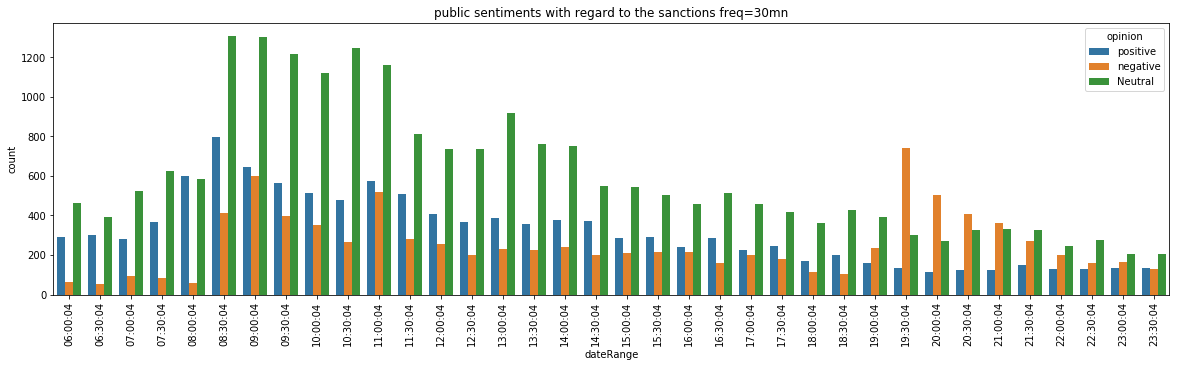

In [49]:
plt.figure(figsize=(20,5))
ax =sns.countplot(data = AfterSanctionsTweet,x = 'dateRange',hue='opinion')
ax.set_xticklabels([tick.get_text()[11:-10] for tick in ax.get_xticklabels()])
plt.xticks(rotation=90)
plt.title('public sentiments with regard to the sanctions freq=30mn')
plt.show()

## Public Opinions extraction :

In [50]:
import spacy
nlp = spacy.load('en_core_web_sm')

C:\Users\Aziz\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning:

cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject

C:\Users\Aziz\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning:

cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject



In [51]:
import re
def preprocess_text(text):  
    #remove HashTags
    text = re.sub(r'#', '', text)    
    text = re.sub(r'RT.*?:\s+', '', text)
    #remove links in tweet
    text = re.sub(r'http.*?\s', '', text, flags=re.MULTILINE)
    text = re.sub(r'http.*', '', text, flags=re.MULTILINE)
    # Remove punctuations and symbols
    text = re.sub('[^a-zA-Z1-9]', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    # removing one to two carachters words
    text= re.sub(r'\b\w{1,2}\b', ' ', text)
    # Removing multiple spaces
    text= re.sub(r'\s+', ' ', text)
    text= text.strip()

    return text

In [52]:
BeforeSanctionsTweet['clean tweets'] = BeforeSanctionsTweet.tweetTxt.apply(lambda tweet : ' '.join([word for word in preprocess_text(tweet).split(' ') if word in nlp.vocab]).lower())
AfterSanctionsTweet['clean tweets'] = AfterSanctionsTweet.tweetTxt.apply(lambda tweet : ' '.join([word for word in preprocess_text(tweet).split(' ') if word in nlp.vocab]).lower())

In [53]:
BeforeSanctionsTweet=BeforeSanctionsTweet[BeforeSanctionsTweet['clean tweets'].apply(lambda txt :  len(txt)) > 4 ]
AfterSanctionsTweet=AfterSanctionsTweet[AfterSanctionsTweet['clean tweets'].apply(lambda txt :  len(txt)) > 4 ]

In [54]:
#import vector embrddings from glove-twitter
import numpy as np
embeddings_index = {}
embeddings_vectors = []
f = open('./glove.twitter.27B.200d.txt', 'rb')

word_idx = 0

for line in f:
    values = line.decode('utf-8').split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = word_idx
    embeddings_vectors.append(vector)
    word_idx = word_idx + 1
f.close()
#del embeddings_vectors[0]
inv_index = {v: k for k, v in embeddings_index.items()}
print(word_idx)

1193514


In [55]:
def get_embedding(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return 0
    else:
        return numberbatch_embeddings[idx]

In [56]:
from nltk.tokenize import word_tokenize

def tokenizeVectorizeTweet(tweets):
    vectorisedData = []
    for tweet in tweets:
        vect = np.zeros(200)
        for token in word_tokenize(tweet) :
            idx = embeddings_index.get(token)
            if idx is not None : 
                vect+= embeddings_vectors[idx]
        vectorisedData.append(vect)
    return vectorisedData

In [57]:
BeforeSanctionsTweet['vect tweets'] = tokenizeVectorizeTweet(BeforeSanctionsTweet['clean tweets'])
AfterSanctionsTweet['vect tweets']  = tokenizeVectorizeTweet(AfterSanctionsTweet['clean tweets'])

## Public opinions one day before the oil sanctions

In [110]:
matrix = pd.DataFrame(BeforeSanctionsTweet['vect tweets'].dropna().values.tolist(),index=BeforeSanctionsTweet['vect tweets'].dropna().index)
matrix.shape

(19697, 200)

In [111]:
from sklearn.cluster import KMeans,DBSCAN,OPTICS

db_scan = DBSCAN(eps=0.05, min_samples=200, metric='cosine', n_jobs=-1)
labels  = db_scan.fit_predict(matrix)

In [112]:
BeforeSanctionsTweet['clusters'] = labels

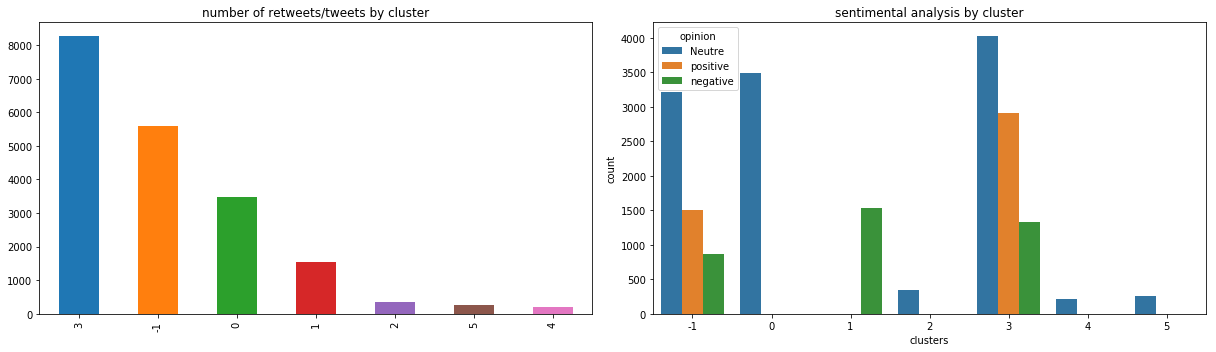

In [113]:
fig,ax=plt.subplots(1,2,figsize=(17,5))
pd.Series(labels).value_counts().plot('bar',ax=ax[0])
ax[0].set_title('number of retweets/tweets by cluster');
sns.countplot(data = BeforeSanctionsTweet,x='clusters',hue='opinion',ax=ax[1])
ax[1].set_title('sentimental analysis by cluster')
plt.tight_layout()
plt.show()

In [114]:
from wordcloud import WordCloud

wordCloudCluster0 = ' '.join(BeforeSanctionsTweet[BeforeSanctionsTweet['clusters']==0]['clean tweets'])
wordCloudCluster1 = ' '.join(BeforeSanctionsTweet[BeforeSanctionsTweet['clusters']==-1]['clean tweets'])
wordCloudCluster2 = ' '.join(BeforeSanctionsTweet[BeforeSanctionsTweet['clusters']==1]['clean tweets'])
wordCloudCluster3 = ' '.join(BeforeSanctionsTweet[BeforeSanctionsTweet['clusters']==2]['clean tweets'])
wordCloudCluster4 = ' '.join(BeforeSanctionsTweet[BeforeSanctionsTweet['clusters']==3]['clean tweets'])
wordCloudCluster5 = ' '.join(BeforeSanctionsTweet[BeforeSanctionsTweet['clusters']==4]['clean tweets'])
wordCloudCluster6 = ' '.join(BeforeSanctionsTweet[BeforeSanctionsTweet['clusters']==5]['clean tweets'])

wordcloud0 = WordCloud(background_color="white" , max_words=50).generate(wordCloudCluster0)
wordcloud1 = WordCloud(background_color="white" , max_words=50).generate(wordCloudCluster1)
wordcloud2 = WordCloud(background_color="white" , max_words=50).generate(wordCloudCluster2)
wordcloud3 = WordCloud(background_color="white" , max_words=50).generate(wordCloudCluster3)
wordcloud4 = WordCloud(background_color="white" , max_words=50).generate(wordCloudCluster4)
wordcloud5 = WordCloud(background_color="white" , max_words=50).generate(wordCloudCluster5)
wordcloud6 = WordCloud(background_color="white" , max_words=50).generate(wordCloudCluster6)

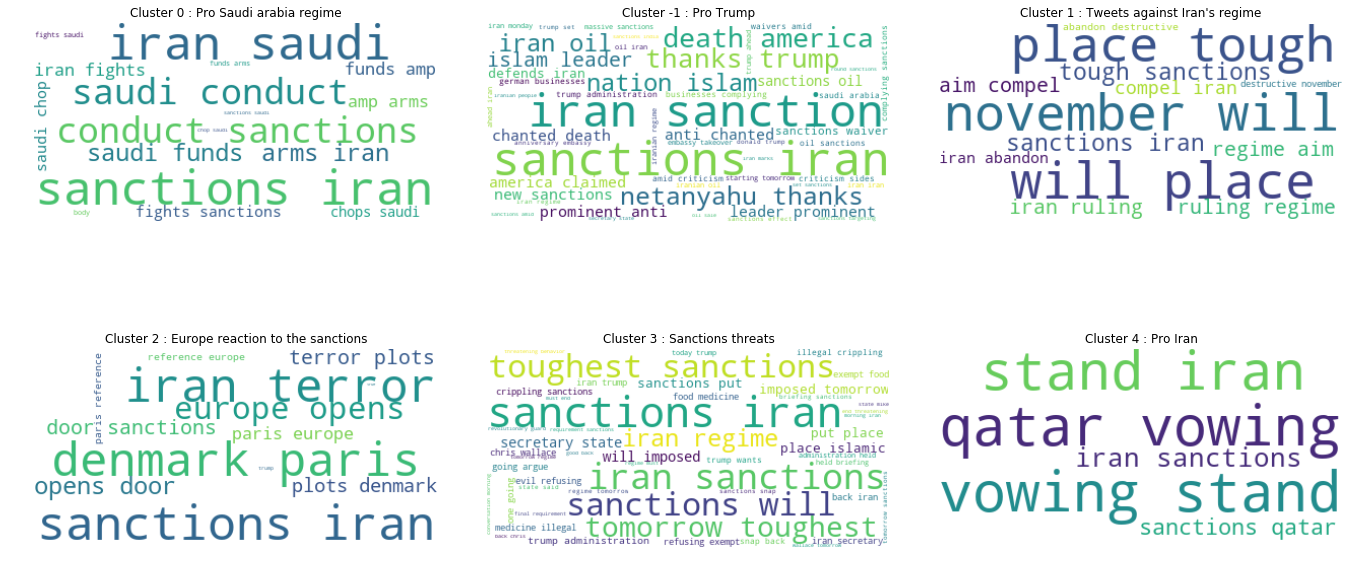

In [115]:
# Display the generated image:
fig,ax = plt.subplots(2,3,figsize=(19,10))
ax[0,0].imshow(wordcloud0, interpolation='bilinear')
ax[0,0].axis("off")
ax[0,0].set_title("Cluster 0 : Pro Saudi arabia regime")
ax[0,1].imshow(wordcloud1, interpolation='bilinear')
ax[0,1].axis("off")
ax[0,1].set_title("Cluster -1 : Pro Trump")
ax[0,2].imshow(wordcloud2, interpolation='bilinear')
ax[0,2].axis("off")
ax[0,2].set_title("Cluster 1 : Tweets against Iran's regime")
ax[1,0].imshow(wordcloud3, interpolation='bilinear')
ax[1,0].axis("off")
ax[1,0].set_title("Cluster 2 : Europe reaction to the sanctions")
ax[1,1].imshow(wordcloud4, interpolation='bilinear')
ax[1,1].axis("off")
ax[1,1].set_title("Cluster 3 : Sanctions threats")
ax[1,2].imshow(wordcloud5, interpolation='bilinear')
ax[1,2].axis("off")
ax[1,2].set_title("Cluster 4 : Pro Iran")
plt.tight_layout()
plt.show()

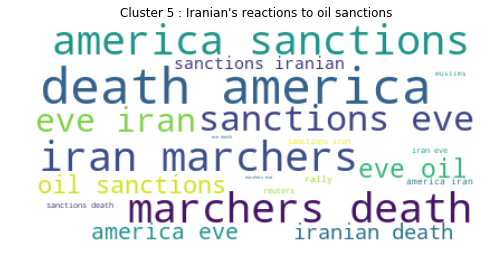

In [116]:
plt.figure(figsize=(8,5))
plt.title("Cluster 5 : Iranian's reactions to oil sanctions")
plt.axis("off")
plt.imshow(wordcloud6, interpolation='bilinear')
plt.show()

## Public opinions one day after the oil sanctions

In [80]:
matrix = pd.DataFrame(AfterSanctionsTweet['vect tweets'].dropna().values.tolist(),index=AfterSanctionsTweet['vect tweets'].dropna().index)
matrix.shape

(41582, 200)

In [81]:
db_scan = DBSCAN(eps=0.04, min_samples=600, metric='cosine', n_jobs=-1)
labels  = db_scan.fit_predict(matrix)

In [83]:
AfterSanctionsTweet['clusters'] = labels

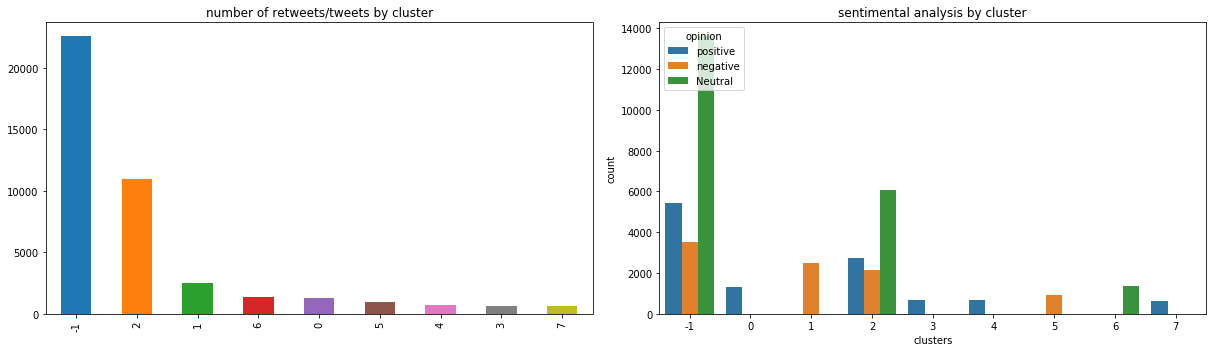

In [107]:
fig,ax=plt.subplots(1,2,figsize=(17,5))
pd.Series(labels).value_counts().plot('bar',ax=ax[0])
ax[0].set_title('number of retweets/tweets by cluster');
sns.countplot(data = AfterSanctionsTweet,x='clusters',hue='opinion',ax=ax[1])
ax[1].set_title('sentimental analysis by cluster')
plt.tight_layout()
plt.show()

In [86]:
wordCloudCluster0 = ' '.join(AfterSanctionsTweet[AfterSanctionsTweet['clusters']==-1]['clean tweets'])
wordCloudCluster1 = ' '.join(AfterSanctionsTweet[AfterSanctionsTweet['clusters']==0]['clean tweets'])
wordCloudCluster2 = ' '.join(AfterSanctionsTweet[AfterSanctionsTweet['clusters']==1]['clean tweets'])
wordCloudCluster3 = ' '.join(AfterSanctionsTweet[AfterSanctionsTweet['clusters']==2]['clean tweets'])
wordCloudCluster4 = ' '.join(AfterSanctionsTweet[AfterSanctionsTweet['clusters']==3]['clean tweets'])
wordCloudCluster5 = ' '.join(AfterSanctionsTweet[AfterSanctionsTweet['clusters']==4]['clean tweets'])
wordCloudCluster6 = ' '.join(AfterSanctionsTweet[AfterSanctionsTweet['clusters']==5]['clean tweets'])
wordCloudCluster7 = ' '.join(AfterSanctionsTweet[AfterSanctionsTweet['clusters']==6]['clean tweets'])
wordCloudCluster8 = ' '.join(AfterSanctionsTweet[AfterSanctionsTweet['clusters']==7]['clean tweets'])

wordcloud0 = WordCloud(background_color="white" , max_words=50).generate(wordCloudCluster0)
wordcloud1 = WordCloud(background_color="white" , max_words=50).generate(wordCloudCluster1)
wordcloud2 = WordCloud(background_color="white" , max_words=50).generate(wordCloudCluster2)
wordcloud3 = WordCloud(background_color="white" , max_words=50).generate(wordCloudCluster3)
wordcloud4 = WordCloud(background_color="white" , max_words=50).generate(wordCloudCluster4)
wordcloud5 = WordCloud(background_color="white" , max_words=50).generate(wordCloudCluster5)
wordcloud6 = WordCloud(background_color="white" , max_words=50).generate(wordCloudCluster6)
wordcloud7 = WordCloud(background_color="white" , max_words=50).generate(wordCloudCluster7)
wordcloud8 = WordCloud(background_color="white" , max_words=50).generate(wordCloudCluster8)

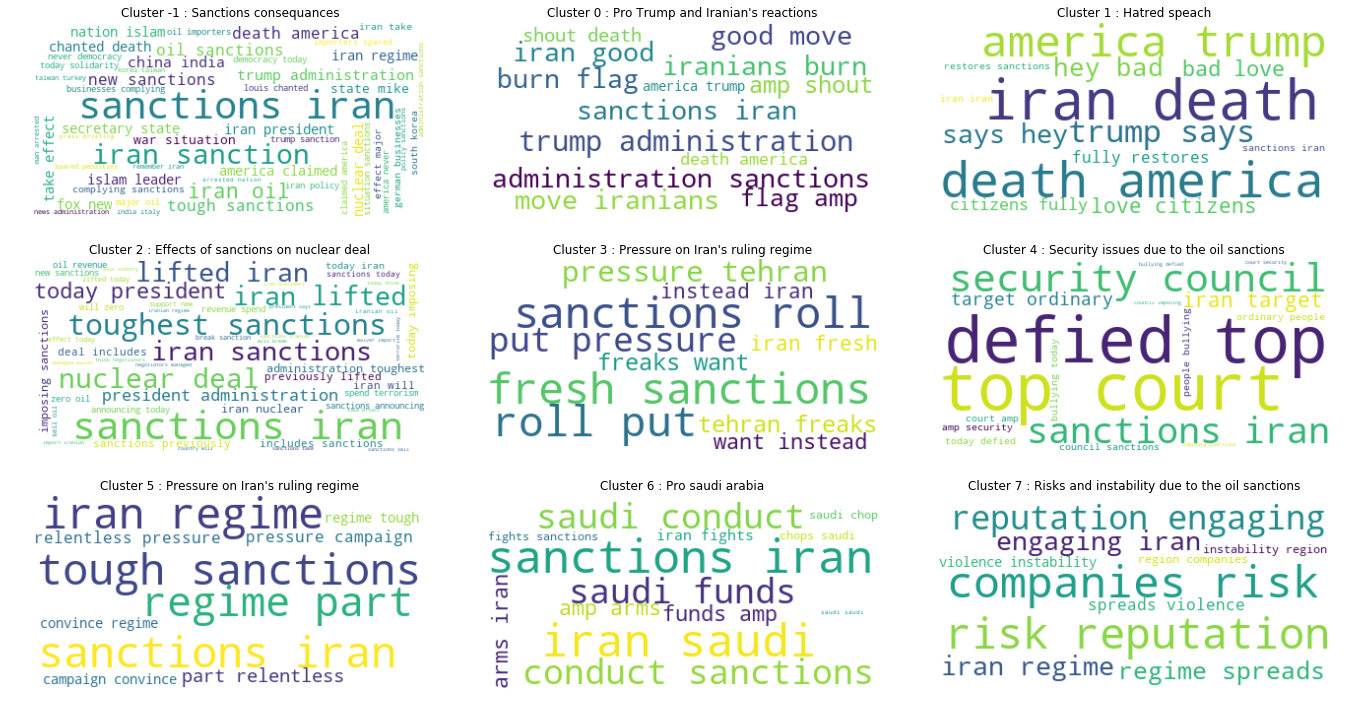

In [109]:
# Display the generated image:
fig,ax = plt.subplots(3,3,figsize=(19,10))

ax[0,0].imshow(wordcloud0, interpolation='bilinear')
ax[0,0].axis("off")
ax[0,0].set_title("Cluster -1 : Sanctions consequances")
ax[0,1].imshow(wordcloud1, interpolation='bilinear')
ax[0,1].axis("off")
ax[0,1].set_title("Cluster 0 : Pro Trump and Iranian's reactions")
ax[0,2].imshow(wordcloud2, interpolation='bilinear')
ax[0,2].axis("off")
ax[0,2].set_title("Cluster 1 : Hatred speach")

ax[1,0].imshow(wordcloud3, interpolation='bilinear')
ax[1,0].axis("off")
ax[1,0].set_title("Cluster 2 : Effects of sanctions on nuclear deal")
ax[1,1].imshow(wordcloud4, interpolation='bilinear')
ax[1,1].axis("off")
ax[1,1].set_title("Cluster 3 : Pressure on Iran's ruling regime")
ax[1,2].imshow(wordcloud5, interpolation='bilinear')
ax[1,2].axis("off")
ax[1,2].set_title("Cluster 4 : Security issues due to the oil sanctions")

ax[2,0].imshow(wordcloud6, interpolation='bilinear')
ax[2,0].axis("off")
ax[2,0].set_title("Cluster 5 : Pressure on Iran's ruling regime")
ax[2,1].imshow(wordcloud7, interpolation='bilinear')
ax[2,1].axis("off")
ax[2,1].set_title("Cluster 6 : Pro saudi arabia")
ax[2,2].imshow(wordcloud8, interpolation='bilinear')
ax[2,2].axis("off")
ax[2,2].set_title("Cluster 7 : Risks and instability due to the oil sanctions")
plt.tight_layout()
plt.show()

Using textblob to extract the sentiment of each tweet wasn't accurate, but clustering using word embeddings, dbscan and cosine similarity, proved we can extract what the public thinks and how people react to the sanctions.